# Mixed that means Residue:Superfeature can be different entries

In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
from dylightful.parser import load_env_partners_mixed

env_partners = load_env_partners_mixed(
    "../tests/Trajectories/ZIKV/ZIKV-Pro-427-1_dynophore.json"
)

In [2]:
import numpy as np

env_partner_arr = []
for partner in env_partners.keys():
    env_partner_arr.append(env_partners[partner])

env_partner_arr = np.array(env_partner_arr)
env_partner_arr.shape
time_ser = env_partner_arr.T
num_feat = time_ser.shape[1]
print(num_feat)

38


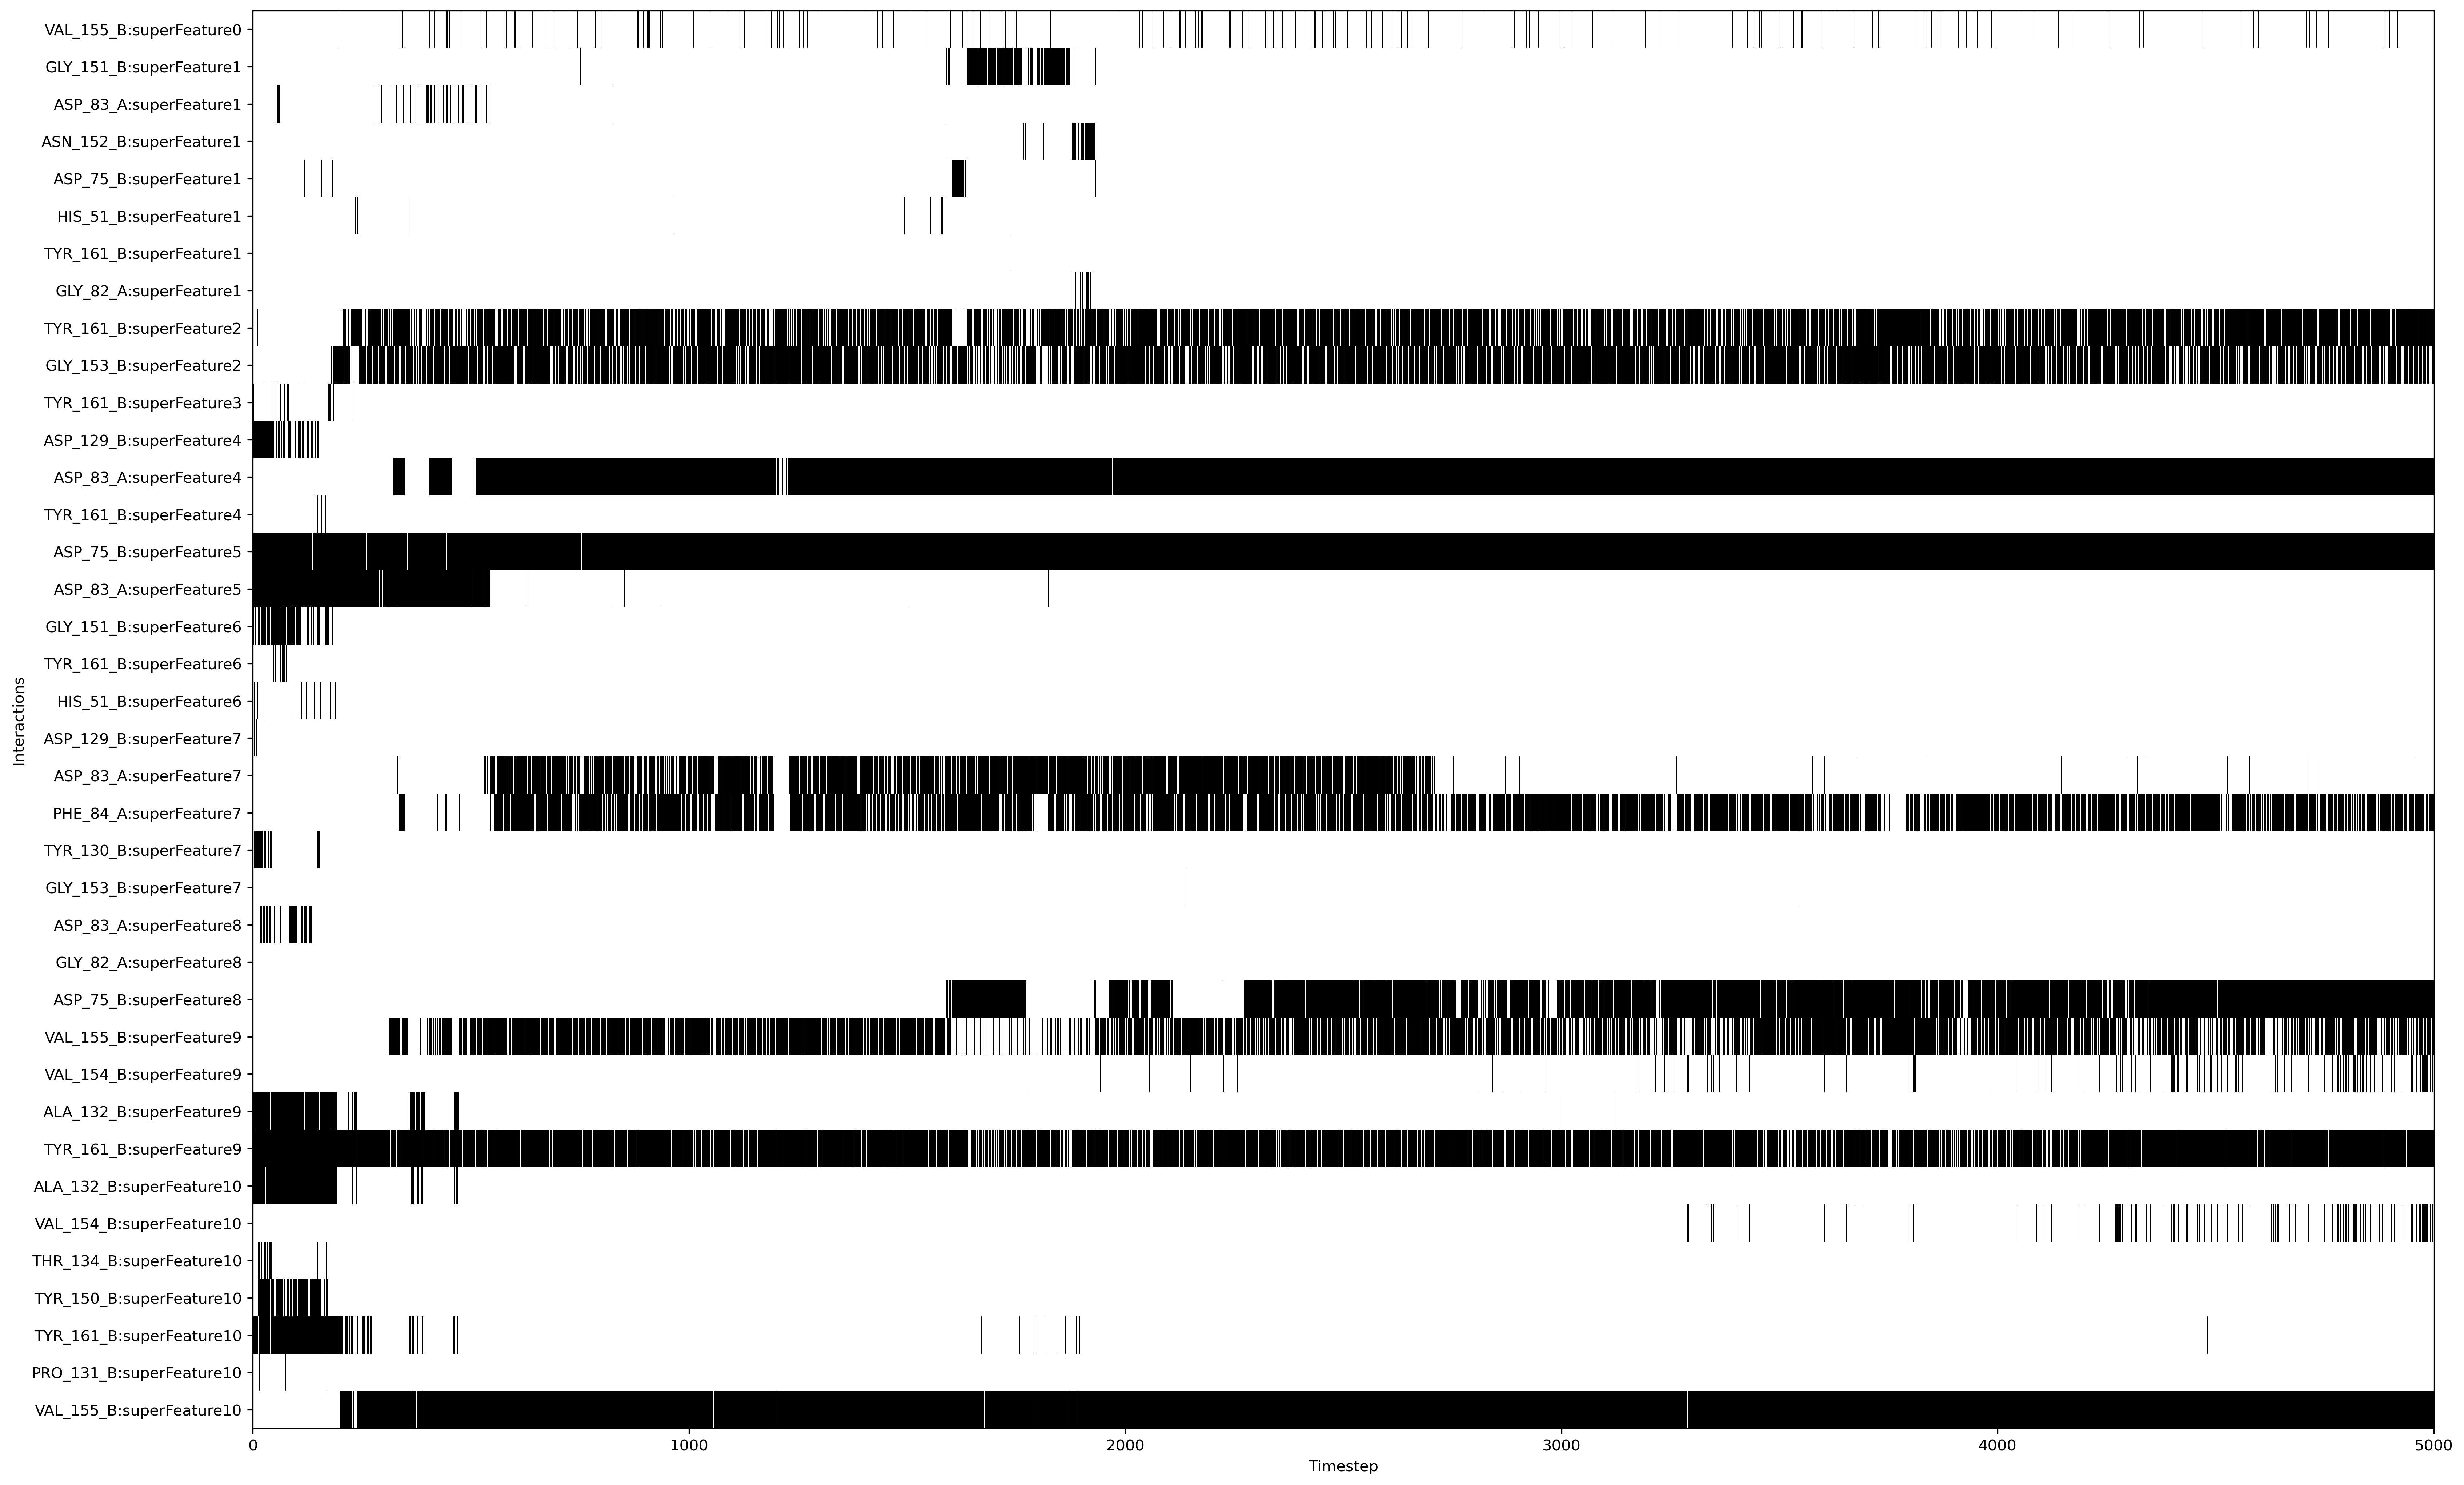

In [12]:
import matplotlib.pyplot as plt
import numpy as np


code = time_ser

pixel_per_bar = 4
dpi = 300

fig = plt.figure(figsize=(20, 13), dpi=dpi)
ax = fig.add_axes([0, 0, 1, 1])  # span the whole figure
ax.imshow(code.T, cmap="binary", aspect="auto", interpolation="nearest")
ax.set_xlabel("Timestep")
ax.set_ylabel("Interactions")
ax.set_yticks(np.arange(len(list(env_partners.keys()))))
ax.set_yticklabels(list(env_partners.keys()))
plt.show()
fig = fig.get_figure()
fig.savefig("ZIKV_barplot_mixed_interaction_full.png", bbox_inches="tight")

In [4]:
import torch

device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
torch.set_num_threads(12)

In [5]:
from deeptime.data import sqrt_model
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from deeptime.util.data import TrajectoryDataset

In [6]:
dataset = TrajectoryDataset(1, time_ser.astype(np.float32))

n_val = int(len(dataset) * 0.5)
train_data, val_data = torch.utils.data.random_split(
    dataset, [len(dataset) - n_val, n_val]
)
print(len(val_data))
loader_train = DataLoader(train_data, batch_size=64, shuffle=False)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)

2500


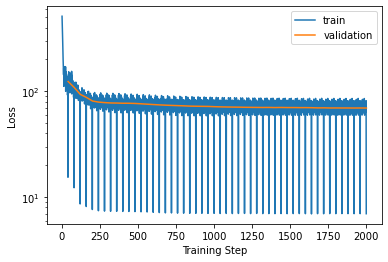

In [7]:
from deeptime.util.torch import MLP
from deeptime.decomposition.deep import TAE

units = [num_feat, 4 * num_feat, 4 * num_feat, 1]
encoder = MLP(
    units,
    nonlinearity=torch.nn.ReLU,
    output_nonlinearity=torch.nn.Sigmoid,
    initial_batchnorm=False,
)
decoder = MLP(units[::-1], nonlinearity=torch.nn.ReLU, initial_batchnorm=False)
tae = TAE(encoder, decoder, learning_rate=1e-3)
tae.fit(loader_train, n_epochs=50, validation_loader=loader_val)
tae_model = tae.fetch_model()

plt.semilogy(*tae.train_losses.T, label="train")
plt.semilogy(*tae.validation_losses.T, label="validation")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.legend();

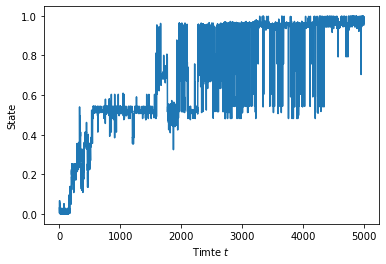

In [8]:
proj = tae_model.transform(time_ser)
plt.ylabel("State")
plt.xlabel("Timte $t$")
plt.plot(np.arange(0, len(proj), 1), proj)

In [9]:
from sklearn.cluster import KMeans
from tqdm import tqdm

random_state = 42
scores = np.zeros(16)
sum_of_squared_distances = np.zeros(16)
for i in range(1, 15):
    clf = KMeans(n_clusters=i, random_state=random_state).fit(proj)
    scores[i] = clf.score(proj)
    sum_of_squared_distances[i] = clf.inertia_

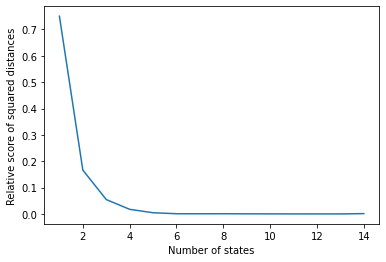

In [10]:
diff = np.abs(np.diff(sum_of_squared_distances[1:] / sum_of_squared_distances[1:][0]))
plt.plot(np.arange(1, len(diff) + 1, 1), diff)
plt.xlabel("Number of states")
plt.ylabel("Relative score of squared distances")
plt.savefig("ZIKV_ellbow_mixed_interaction_full.png", dpi=300)

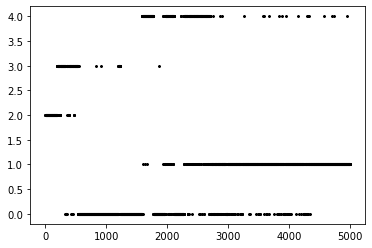

In [11]:
# get labels
clf = KMeans(n_clusters=5, random_state=random_state).fit(proj)
labels = clf.labels_
plt.scatter(np.arange(0, len(time_ser), 1), labels, marker="x", s=4, color="black")
plt.savefig("ZIKV_Discretized_mixed_interactions_Traj.png", dpi=300)

In [12]:
import numpy as np
from deeptime.markov import TransitionCountEstimator

estimator = TransitionCountEstimator(lagtime=1, count_mode="sliding")
counts = estimator.fit(labels).fetch_model()  # fit and fetch the model

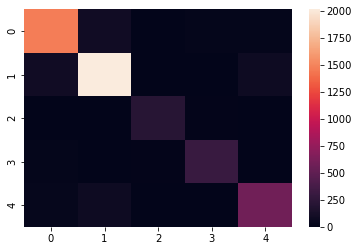

In [13]:
import seaborn as sns

ax = sns.heatmap(counts.count_matrix)
fig = ax.get_figure()
fig.savefig("ZIKV_count_matrix_mixed_interactions_full.png", dpi=300)

In [14]:
import deeptime.markov as markov

estimator = markov.msm.MaximumLikelihoodMSM(
    reversible=True, stationary_distribution_constraint=None
)

msm = estimator.fit(counts).fetch_model()

In [1]:
ax = sns.heatmap(msm.transition_matrix)
fig = ax.get_figure()
fig.savefig("ZIKV_tae_mixed_interaction_full.png", dpi=300)

NameError: name 'sns' is not defined